# Работа 1. Фильтр Калмана (вариант 11)

## 1. Описание системы
Имеется квадрокоптер, летающий над ровным открытым пространством на одной высоте. От него мы регулярно получаем данные об ускорениях по широте и долготе. Оценить положение и скорость квадрокоптера.

В качестве вектора состояния мы берём

$$
\begin{align*}
Z = \left(\begin{array}{c}
              \phi \\
              \theta \\
              \omega_\phi \\
              \omega_\theta \\
              \epsilon_\phi \\
              \epsilon_\theta
          \end{array}\right)
\end{align*}
$$

а в качестве вектора измерений

$$
\begin{align*}
Y = \left(\begin{array}{c}
              \epsilon_\phi \\
              \epsilon_\theta
          \end{array}\right)
\end{align*}
$$

где

$$
\begin{align*}
\phi & - \text{долгота}, \\
\theta & - \text{широта}, \\
\omega_\phi & - \text{скорость по долготе}, \\
\omega_\theta & - \text{скорость по широте}, \\
\epsilon_\phi & - \text{ускорение по долготе}, \\
\epsilon_\theta & - \text{ускорение по широте.}
\end{align*}
$$

## 2. Уравнение состояния и уравнение измерений системы
### Уравнения состояния
Используя разложение в ряд Тейлора, можем перейти от дифференциального уравнения к разностному:

$$
\begin{align*}
\phi(t + \Delta t) & = \phi(t) + \omega_\phi(t) \Delta t + \frac{1}{2} \epsilon_\phi(t) (\Delta t)^2, \\
\theta(t + \Delta t) & = \theta(t) + \omega_\theta(t) \Delta t + \frac{1}{2} \epsilon_\theta(t) (\Delta t)^2, \\
\omega_\phi(t + \Delta t) & = \omega_\phi(t) + \epsilon_\phi(t) \Delta t, \\
\omega_\theta(t + \Delta t) & = \omega_\theta(t) + \epsilon_\theta(t) \Delta t, \\
\epsilon_\phi(t + \Delta t) & = \epsilon_\phi(t), \\
\epsilon_\theta(t + \Delta t) & = \epsilon_\theta(t)
\end{align*}
$$

в матричном виде:

$$
\begin{align*}
Z(t + \Delta t) = F Z(t)
\end{align*}
$$

где

$$
\begin{align*}
F = \left(\begin{array}{cccccc}
              1 && 0 && \Delta t && 0 && \frac{1}{2} (\Delta t)^2 && 0 \\
              0 && 1 && 0 && \Delta t && 0 && \frac{1}{2} (\Delta t)^2 \\
              0 && 0 && 1 && 0 && \Delta t && 0 \\
              0 && 0 && 0 && 1 && 0 && \Delta t \\
              0 && 0 && 0 && 0 && 1 && 0 \\
              0 && 0 && 0 && 0 && 0 && 1
          \end{array}\right)
\end{align*}
$$


$\textbf{Замечание:}$ система линейна, поэтому далее будет применяться обычный фильтр Калмана

### Уравнение измерения
В нашем случае измеряемые переменные есть просто элементы вектора состояния. В матричном виде можно записать

$$
\begin{align*}
Y(t) = H Z(t)
\end{align*}
$$

где

$$
\begin{align*}
H = \left(\begin{array}{cccccc}
              0 && 0 && 0 && 0 && 1 && 0 \\
              0 && 0 && 0 && 0 && 0 && 1 
          \end{array}\right)
\end{align*}
$$

## 3. Тестовые входные сигналы

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def diff(f, dt):
    df = np.diff(f) / dt
    df = np.append(df, df[-1])
    return df

def test_model_circle(noise_val):
    # задаём временной интервал и шаг дискретизации
    T, dt = 40, 0.05
    t = np.arange(0, T, dt)
    # считаем скорость квадрокоптера примерно равной 25 м/с;
    # радиус траектории - 100 м; радиус Земли - примерно 6400 км
    v, r, R_Earth = 25, 100, 6400000
    # задаём центр траектории (окружности)
    phi_0, theta_0 = 90, 0
    # т.к. при малых углах sinx~x, можем так записать движение по окружности
    phi = phi_0 + 180/np.pi * r * np.cos(v/r * t) / R_Earth
    theta = theta_0 + 180/np.pi * r * np.sin(v/r * t) / R_Earth
    # вычисляем первые и вторые производные
    dphi, dtheta = diff(phi, dt), diff(theta, dt)
    ddphi, ddtheta = diff(dphi, dt), diff(dtheta, dt)
    # создаём матрицу, содержащую состояния во все моменты времени
    Z = np.zeros((6, len(t)))
    Z[0], Z[1], Z[2], Z[3], Z[4], Z[5] = phi, theta, dphi, dtheta, ddphi, ddtheta
    # создаём матрицу, содержащую измерения во все моменты времени
    Y = np.zeros((2, len(t)))
    Y[0], Y[1] = ddphi, ddtheta
    # добавляем шум в измерения
    R = 90/np.pi * v**2 / r / R_Earth * np.diag(noise_val)
    Y_noise = np.zeros(Y.shape)
    Y_noise[0] = Y[0] + np.random.normal(0, R[0][0], Y[0].shape)
    Y_noise[1] = Y[1] + np.random.normal(0, R[1][1], Y[1].shape)
    return t, Z, Y, Y_noise, R

def test_model_spiral(noise_val):
    # задаём временной интервал и шаг дискретизации
    T, dt = 40, 0.05
    t = np.arange(0, T, dt)
    # считаем скорость квадрокоптера в начальный момент времени
    # по касательной - 15 м/с, в радиальном направлении - 10 м/с;
    # начальный радиус траектории - 75 м; радиус Земли - примерно 6400 км
    v_r, v_tan, r_0, R_Earth = 10, 15, 75, 6400000
    # задаём центр траектории (спирали)
    phi_0, theta_0 = 90, 0
    # т.к. при малых углах sinx~x, можем так записать движение по спирали
    phi = phi_0 + 180/np.pi * (r_0 + v_r * t) * np.cos(v_tan/r_0 * t) / R_Earth
    theta = theta_0 + 180/np.pi * (r_0 + v_r * t) * np.sin(v_tan/r_0 * t) / R_Earth
    # вычисляем первые и вторые производные
    dphi, dtheta = diff(phi, dt), diff(theta, dt)
    ddphi, ddtheta = diff(dphi, dt), diff(dtheta, dt)
    # создаём матрицу, содержащую состояния во все моменты времени
    Z = np.zeros((6, len(t)))
    Z[0], Z[1], Z[2], Z[3], Z[4], Z[5] = phi, theta, dphi, dtheta, ddphi, ddtheta
    # создаём матрицу, содержащую измерения во все моменты времени
    Y = np.zeros((2, len(t)))
    Y[0], Y[1] = ddphi, ddtheta
    # добавляем шум в измерения
    R = 90/np.pi * (v_tan**2 + v_r**2) / r_0 / R_Earth * np.diag(noise_val)
    Y_noise = np.zeros(Y.shape)
    Y_noise[0] = Y[0] + np.random.normal(0, R[0][0], Y[0].shape)
    Y_noise[1] = Y[1] + np.random.normal(0, R[1][1], Y[1].shape)
    return t, Z, Y, Y_noise, R

def test_model_sin(noise_val):
    # задаём временной интервал и шаг дискретизации
    T, dt = 40, 0.05
    t = np.arange(0, T, dt)
    # считаем скорость квадрокоптера по экватору - 15 м/с,
    # средняя скорость вдоль меридиана ~ 10 м/с;
    # максимальное отклонение от экватора - 75 м; радиус Земли - примерно 6400 км
    v_e, v_m, r, R_Earth = 15, 15, 75, 6400000
    # задаём начальное положение
    phi_0, theta_0 = 90, 0
    # т.к. при малых углах sinx~x, можем так записать уравнение движения
    phi = phi_0 + 180/np.pi * v_m * t / R_Earth
    theta = theta_0 + 180/np.pi * r * np.sin(v_e/r * t) / R_Earth
    # вычисляем первые и вторые производные
    dphi, dtheta = diff(phi, dt), diff(theta, dt)
    ddphi, ddtheta = diff(dphi, dt), diff(dtheta, dt)
    # создаём матрицу, содержащую состояния во все моменты времени
    Z = np.zeros((6, len(t)))
    Z[0], Z[1], Z[2], Z[3], Z[4], Z[5] = phi, theta, dphi, dtheta, ddphi, ddtheta
    # создаём матрицу, содержащую измерения во все моменты времени
    Y = np.zeros((2, len(t)))
    Y[0], Y[1] = ddphi, ddtheta
    # добавляем шум в измерения
    R = 90/np.pi * v_e**2 / r / R_Earth * np.diag(noise_val)
    Y_noise = np.zeros(Y.shape)
    Y_noise[0] = Y[0] + np.random.normal(0, R[0][0], Y[0].shape)
    Y_noise[1] = Y[1] + np.random.normal(0, R[1][1], Y[1].shape)
    return t, Z, Y, Y_noise, R

## 4. Фильтр Калмана

In [3]:
def F_linear(dt):
    return np.array([[1, 0, dt, 0, dt**2 / 2, 0],
                     [0, 1, 0, dt, 0, dt**2 / 2],
                     [0, 0, 1, 0, dt, 0],
                     [0, 0, 0, 1, 0, dt],
                     [0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])

def H_linear():
    return np.array([[0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])

def kalman_step(y, z0, P0, Q, R, dt):
    """ Вычисляет вектор состояния и матрицу ковариации системы на следующем шаге
    y --- вектор-столбец Mx1; вектор измерений на следующем шаге
    z0 --- вектор-столбец Nx1; состояние системы на текущем шаге
    P0 --- матррца NxN; матрица ковариации системы на текущем шаге
    Q --- матрица ковариации ошибок состояния системы
    R --- матрица ковариаций ошибок измерений
    dt --- шаг дискретизации системы
    """
    # создаём матрицы системы
    F = F_linear(dt)
    H = H_linear()
    # оценка нового состояния из прошлого
    z = F @ z0
    P = F @ P0 @ F.T + Q
    # корректирующий член
    e = y - H @ z
    G = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
    # коррекция
    z = z + G @ e
    P = (np.eye(len(z0)) - G @ H) @ P
    return z, P

def kalman(Y, z0, P0, Q, R, dt):
    """ Возвращает матрицу, столбцы которой - состояния в последовательные моменты времени
    Y --- матрица, столбцы которой - измерения в последовательные моменты времени
    z0 --- вектор-столбец Nx1; начальное состояние системы
    P0 --- матррца NxN; начальная матрица ковариации системы
    Q --- матрица ковариации ошибок состояния системы
    R --- матрица ковариаций ошибок измерений
    dt --- шаг дискретизации системы
    """
    # создаём матрицу, хранящую результат - столбы есть состояния
    # в последовательные моменты времени
    z_res = np.zeros((len(z0), Y.shape[1]))
    # задаём начальные условия; в z и P будут сохраняться состояние 
    # системы и матрица ковариации системы
    z_res[:, 0] = z0
    z = z0
    P = P0
    # цикл, в котором последовательно вычисляются состояние и матрица 
    # ковариации системы
    for i in range(1, z_res.shape[1]):
        z, P = kalman_step(Y[:, i], z, P, Q, R, dt)
        z_res[:, i] = z
    return z_res

## 5. Проверка работы фильтра

In [9]:
def show(t, Z, P0, Y, Q, R):
    dt = t[1] - t[0]
    z0 = Z[:, 0]
    Z_filtered = kalman(Y, z0, P0, Q, R, dt)
    
    plt.title("Quadrocopter positions") 
    plt.xlabel("lon") 
    plt.ylabel("lat") 
    # точное положение
    plt.plot(Z[0], Z[1], color='r') 
    # оценка по показаниям приборов
    plt.plot(Z_filtered[0], Z_filtered[1], color='g')
    plt.show()
    
    plt.title("Quadrocopter speed") 
    plt.xlabel("dlon/dt") 
    plt.ylabel("dlat/dt") 
    # точная скорость
    plt.plot(Z[2], Z[3], color='r') 
    # оценка по показаниям приборов
    plt.plot(Z_filtered[2], Z_filtered[3], color='g')
    plt.show()

### Чистые данные

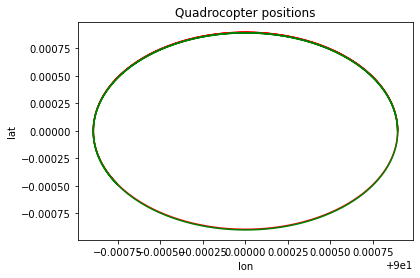

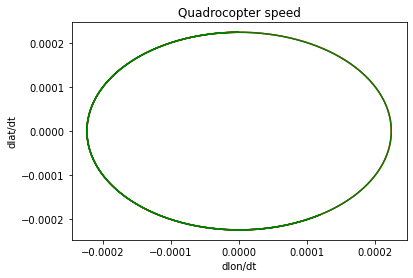

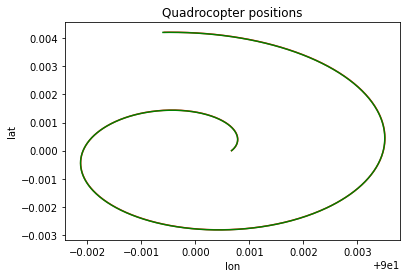

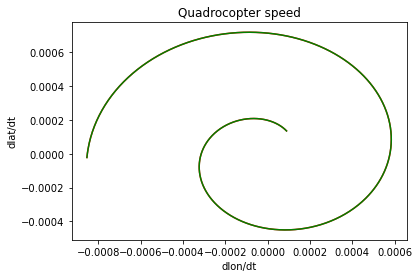

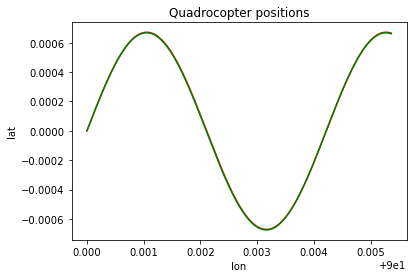

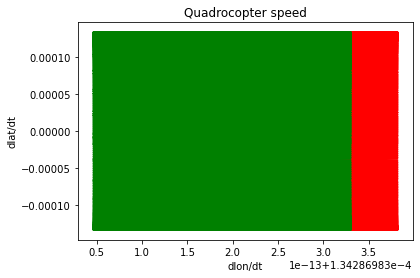

In [11]:
R_noise_val = [0.1, 0.1]
P0 = 0.01 * np.eye(6)
Q = 0.1 * np.eye(6)

# окружность
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y, Q, R)

# спираль
t, Z, Y, Y_noise, R = test_model_spiral(R_noise_val)
show(t, Z, P0, Y, Q, R)

# синусоида
t, Z, Y, Y_noise, R = test_model_sin(R_noise_val)
show(t, Z, P0, Y, Q, R)

### Зашумлённые данные

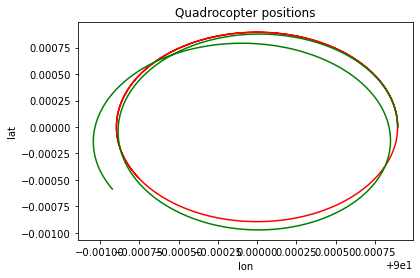

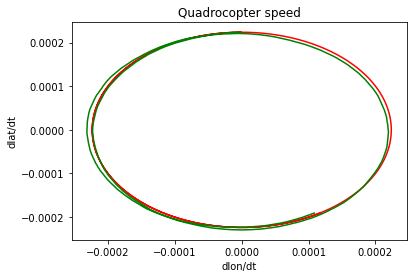

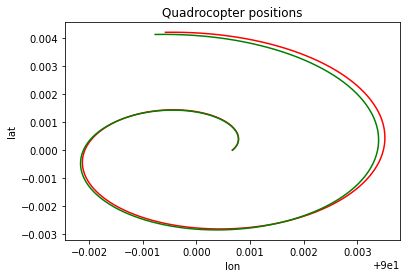

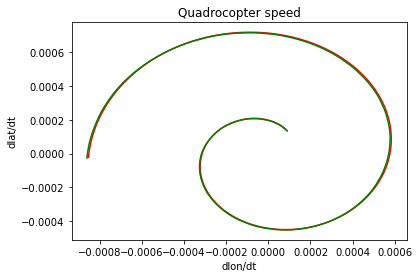

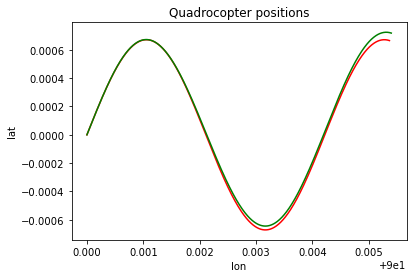

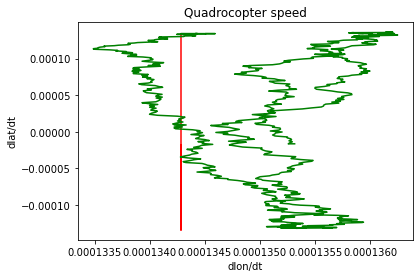

In [13]:
R_noise_val = [0.1, 0.1]
P0 = 0.01 * np.eye(6)
Q = 0.1 * np.eye(6)

# окружность
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)

# спираль
t, Z, Y, Y_noise, R = test_model_spiral(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)

# синусоида
t, Z, Y, Y_noise, R = test_model_sin(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)

## 6. Реакция фильтра на изменение шума
### Шум измерений

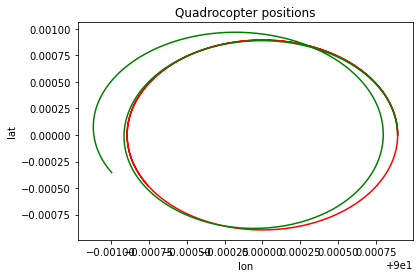

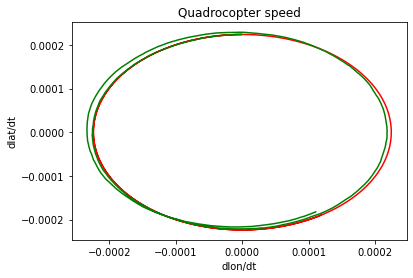

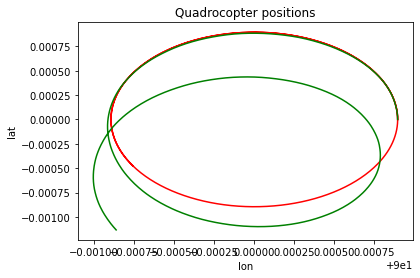

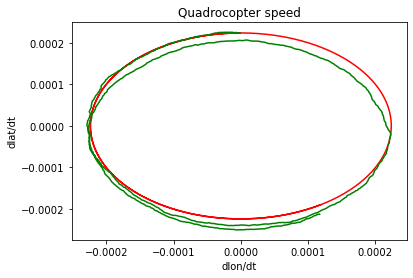

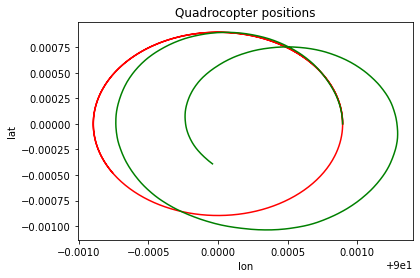

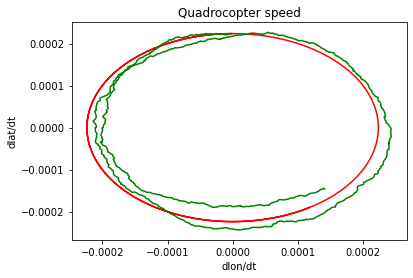

In [14]:
# рассматриваем влияние шума на примере окружности
P0 = 0.01 * np.eye(6)
Q = 0.1 * np.eye(6)
#
R_noise_val = [0.1, 0.1]
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)
#
R_noise_val = [0.4, 0.4]
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)
#
R_noise_val = [0.8, 0.8]
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)

### Шум процесса

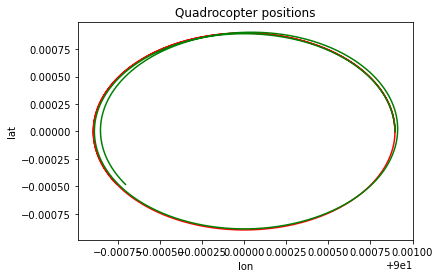

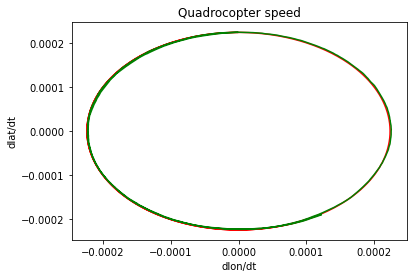

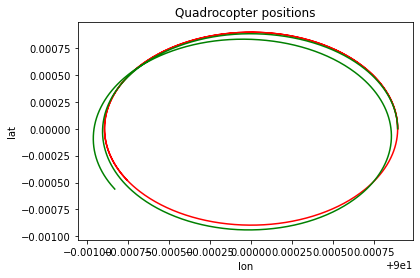

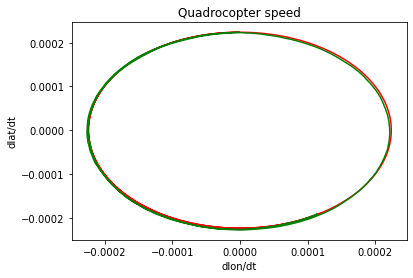

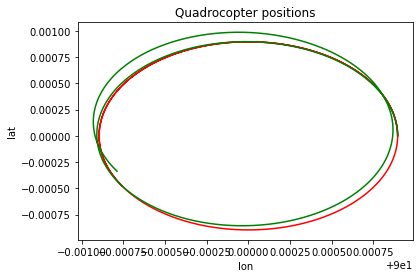

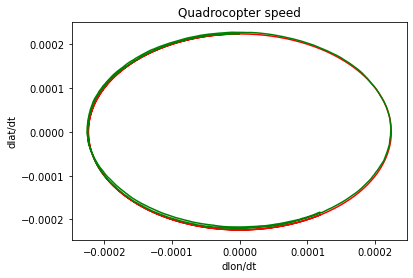

In [15]:
# рассматриваем влияние шума на примере окружности
P0 = 0.01 * np.eye(6)
R_noise_val = [0.1, 0.1]
#
Q = 0.1 * np.eye(6)
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)
#
Q = 0.5 * np.eye(6)
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)
#
Q = 0.9 * np.eye(6)
t, Z, Y, Y_noise, R = test_model_circle(R_noise_val)
show(t, Z, P0, Y_noise, Q, R)

## 7. Устойчивость решения

Из рисунков видно, что со временем происходит накопление ошибок. Следовательно, полученное решение задачи неустойчиво